# I'm not sure why, but my fancy pipelines seem to only get <0.40
Let's start with https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough, who got at least 0.42 in the notebook, then see where I went wrong. I'll import my existing tools when relevant but otherwise do all the work in the notebook for now

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [70]:
# Tools for developing code
%load_ext autoreload 
%autoreload 2

# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.model import kfold, f1_scorer

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [5]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

## Correct labels for households with multiple labels

In [6]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


In [7]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


## Correct missingness

In [8]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


In [9]:
# Missing num tablets means you don't have one
data['v18q1'] = data['v18q1'].fillna(0)

# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

In [10]:
id_ = ['Id', 'idhogar', 'Target']

ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

print('There are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])

There are no repeats:  True
We covered every variable:  True


In [11]:
# Remove squared variables
data = data.drop(columns = sqr_)

heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

## Redundant Household Variables

In [12]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

In [13]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']

In [14]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

In [15]:
heads = heads.drop(columns = 'area2')

In [16]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)

# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']


# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

In [17]:
household_feats = list(heads.columns)

## Process individual-level features

In [18]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

In [19]:
# Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

In [20]:
ind = ind.drop(columns = 'male')

In [21]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

In [22]:
ind.shape

(33413, 40)

In [23]:
ind['escolari/age'] = ind['escolari'] / ind['age']

ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()




count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

In [24]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                ...    inst/age  \
           min max sum count  std range_ min max sum count  ...         sum   
idhogar                                                     ...               
000a08204    1   1   3     3  0.0      0   0   0   0     3  ...    0.483333   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  ...    0.016667   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  ...    0.511959   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...    0.184211   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...    0.213768   

                                    tech                            
          count       std    range_  min max sum count  std range_  
idhogar                                                             
000a08204     3  0.139775  0.250000    2   2   6     3  0.0      0  
000bce7c4     2  0.011785  0.016667    1   1   2     2  0.0      0  
001845fb0     4  0.060123  0.128205    1   1   4     4  0.0      0  
001ff74ca     1       NaN  0.000000    2   2   4     2  0.0      0  
003123ec2     4  0.064636  0.130435    1   1   4     4  0.0      0  

[5 rows x 234 columns]

In [25]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,...,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,...,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,...,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,...,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,...,0.184211,1,NaN,0.000000,2,2,4,2,0.0,0
003123ec2,0,0,0,4,0.0,0,0,0,0,4,...,0.213768,4,0.064636,0.130435,1,1,4,4,0.0,0


In [26]:
# Create correlation matrix
corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

There are 111 correlated columns to remove.


In [27]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)

Final features shape:  (10307, 228)


In [28]:
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final = final.merge(head_gender, on = 'idhogar', how = 'left').rename(columns = {'female': 'female-head'})
final.groupby('female-head')['Target'].value_counts(normalize=True)

female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

## Model

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [30]:
# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [31]:
# Labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extract the training data
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

# Submission base which is used for making submissions to the competition
submission_base = test[['Id', 'idhogar']].copy()

In [32]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

In [33]:
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3425 with std = 0.0322


In [34]:
model.fit(train_set, train_labels)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000643
1,hacapo,0.000283
2,v14a,0.000460
3,refrig,0.001798
4,paredblolad,0.006024


## Feature selection

In [35]:
train_set = pd.DataFrame(train_set, columns = features)

# Create correlation matrix
corr_matrix = train_set.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'elec', 'v18q-count', 'female-sum']

In [36]:
train_set = train_set.drop(columns = to_drop)
train_set.shape

(2973, 222)

In [37]:
test_set = pd.DataFrame(test_set, columns = features)
train_set, test_set = train_set.align(test_set, axis = 1, join = 'inner')
features = list(train_set.columns)

In [38]:
from sklearn.feature_selection import RFECV

# Create a model for feature selection
estimator = RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)

# Create the object
selector = RFECV(estimator, step = 1, cv = 3, scoring= scorer, n_jobs = -1)

63

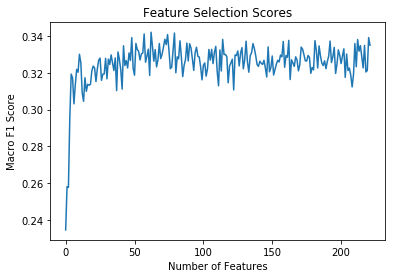

In [39]:
%%time
selector.fit(train_set, train_labels)

plt.plot(selector.grid_scores_);

plt.xlabel('Number of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores');
selector.n_features_

In [40]:
rankings = pd.DataFrame({'feature': list(train_set.columns), 'rank': list(selector.ranking_)}).sort_values('rank')
rankings.head(10)

,feature,rank
73,r4h2,1
130,estadocivil7-std,1
129,estadocivil7-sum,1
198,escolari-sum,1
197,escolari-max,1
86,bedrooms,1
177,instlevel4-std,1
109,female-std,1
106,dis-sum,1
187,instlevel8-sum,1


In [41]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)

In [42]:
# Convert back to dataframe
selected_features = train_set.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns = selected_features)
test_selected = pd.DataFrame(test_selected, columns = selected_features)

Upgrading Our Model: Gradient Boosting Machine
After using the Random Forest and getting decent scores, it's time to step up and use the gradient boosting machine. If you spend any time on Kaggle, you'll notice that the Gradient Boosting Machine (GBM) wins a high percentage of competitions where the data is structured (in tables) and the datasets are not that large (less than a million observations).

I won't go too much into the details here, but instead will focus on the implementation. We'll use the GBM in LightGBM, although there are also options in Scikit-Learn, XGBOOST, and CatBoost. The first set of hyperparameters we'll use were based on those I've found have worked well for other problems.

Choosing Number of Estimators with Early Stopping
To choose the number of estimators (the number of decision trees in the ensemble, called n_estimators or num_boost_rounds), we'll use early stopping with 5-fold cross validation. This will keep adding estimators until the performance as measured by the Macro F1 Score has not increased for 100 training rounds. To use this metric, we'll have to define a custom metric.

In [43]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

In [44]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, test_ids, 
              nfolds = 5, return_preds = False, hyp = None):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of esimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}
    
    # Build the model
    model = lgb.LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    # Fill in the individuals that do not have a head of household with 4 since these will not be scored
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances along with validation scores
    return submission, feature_importances, valid_scores

In [45]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

In [46]:
%%capture --no-display
predictions, gbm_fi = model_gbm(train_set, train_labels, test_set, test_ids, return_preds=True)

'Fold 1, Validation Score: 0.45854, Estimators Trained: 201'

'Fold 2, Validation Score: 0.39228, Estimators Trained: 121'

'Fold 3, Validation Score: 0.41043, Estimators Trained: 17'

'Fold 4, Validation Score: 0.42048, Estimators Trained: 275'

'Fold 5, Validation Score: 0.45453, Estimators Trained: 335'

'5 cross validation score: 0.42725 with std: 0.02559.'

In [47]:
predictions.head()

,1,2,3,4,idhogar,fold,Target,confidence
0,0.153845,0.148401,0.153716,0.544038,72958b30c,1,4,0.544038
1,0.200000,0.146805,0.140883,0.512312,5b598fbc9,1,4,0.512312
2,0.172124,0.175594,0.240187,0.412094,1e2fc704e,1,4,0.412094
3,0.167223,0.179329,0.171756,0.481693,8ee7365a8,1,4,0.481693
4,0.151113,0.173359,0.182136,0.493391,ff69a6fc8,1,4,0.493391


In [48]:
gbm_fi.sort_values('importance', ascending=False).head()

,feature,importance
69,meaneduc,1007.0
204,age-std,998.8
211,escolari/age-sum,919.6
203,age-sum,874.2
202,age-max,870.0


## TODO
- I really don't understand how this precise implementation is different than a regular one. It seems that it uses soft voting within the function (because you are looping through the kfold and aggregating predictions). This is different than what cross-validation scoring is (indeed, when you run cross-validation scoring on this function, you split the data twice, right?)
- can it make a learning curve?
- Use some sort of hyperparameter tuning, but it WILL be slow! https://www.kaggle.com/aashita/advanced-pipelines-tutorial




In [63]:
from xgboost import XGBClassifier

In [61]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(features, labels, test_size=0.25)

In [125]:
%%time
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.02, max_depth=10)
xgb.fit(train_X, train_y, early_stopping_rounds=100, 
             eval_set=[(test_X, test_y)], verbose=False)

Wall time: 2.15 s


In [127]:
%%time
fit_params = {"eval_set": [(test_X, test_y)], 
              "early_stopping_rounds": 100, 
              "verbose": False} 
cv_score = cross_val_score(xgb, train_X, train_y, cv=kfold, scoring=f1_scorer, n_jobs=-1, fit_params=fit_params)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

Cross Validation F1 Score = 0.3816 with std = 0.0187
Wall time: 1min 35s


In [78]:
params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}

model = lgb.LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)



In [81]:
%%time
fit_params = {"eval_set": [(test_X, test_y)], 
              "early_stopping_rounds": 100, 
              "verbose": False} 
cv_score = cross_val_score(model, train_X, train_y, cv=kfold, scoring=f1_scorer, n_jobs=-1, fit_params=fit_params)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

Cross Validation F1 Score = 0.4113 with std = 0.0175
Wall time: 4min 46s


In [82]:
%%time
fit_params = {"eval_set": [(test_X, test_y)], 
              "early_stopping_rounds": 50, 
              "verbose": False} 
cv_score = cross_val_score(model, train_X, train_y, cv=kfold, scoring=f1_scorer, n_jobs=-1, fit_params=fit_params)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

Cross Validation F1 Score = 0.4093 with std = 0.0156
Wall time: 4min 14s


In [83]:
model.fit(train_X, train_y, early_stopping_rounds=100, 
             eval_set=[(test_X, test_y)], verbose=False)

LGBMClassifier(boosting_type='dart', class_weight='balanced',
        colsample_bytree=0.88, learning_rate=0.028, max_depth=-1,
        min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=10000, n_jobs=-1, num_leaves=36,
        objective='multiclass', random_state=10, reg_alpha=0.76,
        reg_lambda=0.43, silent=True, subsample=0.54,
        subsample_for_bin=40000, subsample_freq=0)

In [84]:
feature_importances = pd.DataFrame({'feature': feature_names,
                                    'importance': model.feature_importances_})

In [86]:
feature_importances.sort_values('importance', ascending=False).head()

,feature,importance
204,age-std,6042
202,age-max,5424
211,escolari/age-sum,4836
201,age-min,4721
203,age-sum,4600


## Hyperparameter tuning: 
Really can't figure out https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough. Below I try using his best parameters, but they do very poorly. Guessing by his high learning rate and low n_estimators, I wonder if this is best because his algorithm splits data into 5 folds with soft voting, whereas the regular implementation would have just one training set. 
It seems that https://github.com/hyperopt/hyperopt-sklearn/blob/master/notebooks/Demo-Iris.ipynb has some but not all sklearn algorithms included. 


### TODO: try https://www.kaggle.com/yassinealouini/hyperopt-the-xgboost-model

In [103]:
best_hyp = {'boosting_type': 'dart',
 'colsample_bytree': 0.6096416248120604,
 'learning_rate': 0.19779582059725404,
 'limit_max_depth': True,
 'max_depth': 24,
 'min_child_samples': 35,
 'num_leaves': 42,
 'reg_alpha': 0.41161294322049163,
 'reg_lambda': 0.6745579773545685,
 'subsample_for_bin': 50000,
 'drop_rate': 0.48718668776524016,
 'subsample': 0.5220648456225067,
 'subsample_freq': 9,
 'n_estimators': 120}

In [105]:
model = lgb.LGBMClassifier(**best_hyp, objective = 'multiclass', 
                               n_jobs = -1,
                               random_state = 10)

In [124]:
%%time
fit_params = {"eval_set": [(test_X, test_y)], 
              "early_stopping_rounds": 100, 
              "verbose": False} 
cv_score = cross_val_score(model, train_X, train_y, cv=kfold, scoring=f1_scorer, n_jobs=-1, fit_params=fit_params)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

Cross Validation F1 Score = 0.4084 with std = 0.01
Wall time: 2min 6s


## Well, let's at least do a very quick check of different max_depts
Note: of [12,16,20,25,30,35,40], max_depth=20 performed the best!

In [109]:
from sklearn.model_selection import GridSearchCV

In [113]:
%%time

param_grid = dict(max_depth=[12,16,20])

params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   #'num_leaves': 36, 
                   'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}

fit_params = {"eval_set": [(test_X, test_y)], 
              "early_stopping_rounds": 100, 
              "verbose": False} 

model = lgb.LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)

grid = GridSearchCV(model, param_grid=param_grid, fit_params=fit_params, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(train_X, train_y)


Wall time: 8min 37s


In [118]:
%%time
param_grid = dict(num_leaves=[32,36,40])
params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 
                   'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}


grid = GridSearchCV(model, param_grid=param_grid, fit_params=fit_params, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(train_X, train_y)


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...ggle\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\runpy.py in _run_code(code=<code object <module> at 0x00000179129BCC00, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\users\zrankin\appdata\local\continuum\minicon...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'c:\users\zrankin\appdata\local\continuum\minicon...vs\kaggle\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...ggle\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\users\\z...le\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...ggle\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000179129BCC00, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\users\zrankin\appdata\local\continuum\minicon...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'c:\users\zrankin\appdata\local\continuum\minicon...vs\kaggle\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...ggle\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\users\\z...le\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    492         if self.poller is not None:
    493             self.poller.start()
    494         self.kernel.start()
    495         self.io_loop = ioloop.IOLoop.current()
    496         try:
--> 497             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    498         except KeyboardInterrupt:
    499             pass
    500 
    501 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1429                         logger.warning('Executing %s took %.3f seconds',
   1430                                        _format_handle(handle), dt)
   1431                 finally:
   1432                     self._current_handle = None
   1433             else:
-> 1434                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(836, 1)>>
   1435         handle = None  # Needed to break cycles when an exception occurs.
   1436 
   1437     def _set_coroutine_wrapper(self, enabled):
   1438         try:

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\asyncio\events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(836, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (836, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\tornado\platform\asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=836, events=1)
    117             self.writers.remove(fd)
    118         del self.handlers[fd]
    119 
    120     def _handle_events(self, fd, events):
    121         fileobj, handler_func = self.handlers[fd]
--> 122         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    123 
    124     def start(self):
    125         try:
    126             old_loop = asyncio.get_event_loop()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\nparam_grid = dict(num_leaves=[32,36,40])\n...f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 1, 13, 14, 27, 573857, tzinfo=tzutc()), 'msg_id': 'd9fd04005580454482dd4ca154eb03a0', 'msg_type': 'execute_request', 'session': 'eb2930d46f4343ae830dd7998ec63da8', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'd9fd04005580454482dd4ca154eb03a0', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warning("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'eb2930d46f4343ae830dd7998ec63da8']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\nparam_grid = dict(num_leaves=[32,36,40])\n...f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 1, 13, 14, 27, 573857, tzinfo=tzutc()), 'msg_id': 'd9fd04005580454482dd4ca154eb03a0', 'msg_type': 'execute_request', 'session': 'eb2930d46f4343ae830dd7998ec63da8', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'd9fd04005580454482dd4ca154eb03a0', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'eb2930d46f4343ae830dd7998ec63da8'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\nparam_grid = dict(num_leaves=[32,36,40])\n...f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 1, 13, 14, 27, 573857, tzinfo=tzutc()), 'msg_id': 'd9fd04005580454482dd4ca154eb03a0', 'msg_type': 'execute_request', 'session': 'eb2930d46f4343ae830dd7998ec63da8', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'd9fd04005580454482dd4ca154eb03a0', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='%%time\nparam_grid = dict(num_leaves=[32,36,40])\n...f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)\n', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '%%time\nparam_grid = dict(num_leaves=[32,36,40])\n...f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)\n'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('%%time\nparam_grid = dict(num_leaves=[32,36,40])\n...f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)\n',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('%%time\nparam_grid = dict(num_leaves=[32,36,40])\n...f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)\n',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='%%time\nparam_grid = dict(num_leaves=[32,36,40])\n...f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)\n', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = '%%time\nparam_grid = dict(num_leaves=[32,36,40])\n...f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)\n'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='%%time\nparam_grid = dict(num_leaves=[32,36,40])\n...f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)\n', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-118-ccf4e0ac5cf0>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 17938c7fe10, executio...rue silent=False shell_futures=True> result=None>)
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])
   2906                 code = compiler(mod, cell_name, "single")
-> 2907                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000017938A8BC90, file "<ipython-input-118-ccf4e0ac5cf0>", line 1>
        result = <ExecutionResult object at 17938c7fe10, executio...rue silent=False shell_futures=True> result=None>
   2908                     return True
   2909 
   2910             # Flush softspace
   2911             if softspace(sys.stdout, 0):

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000017938A8BC90, file "<ipython-input-118-ccf4e0ac5cf0>", line 1>, result=<ExecutionResult object at 17938c7fe10, executio...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000017938A8BC90, file "<ipython-input-118-ccf4e0ac5cf0>", line 1>
        self.user_global_ns = {'Counter': <class 'collections.Counter'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HyperoptEstimator': <class 'hpsklearn.estimator.hyperopt_estimator'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', "import os\nimport sys\nimport numpy as np\nimport p..._ipython().run_line_magic('matplotlib', 'inline')", '# # Tools for developing code\n# %load_ext autore...t in sys.path:\n#     sys.path.append(module_path)', "train = pd.read_csv('../input/train.csv')\ntest = pd.read_csv('../input/test.csv')", 'mapping = {"yes": 1, "no": 0}\n\n# Apply same oper...in[[\'dependency\', \'edjefa\', \'edjefe\']].describe()', "# Add null Target column to test\ntest['Target'] ...an\ndata = train.append(test, ignore_index = True)", "# Groupby the household and figure out the numbe...ll have the same target.'.format(len(not_equal)))", "# Iterate through each household\nfor household i...ll have the same target.'.format(len(not_equal)))", "# Number of missing in each column\nmissing = pd....cent', ascending = False).head(10).drop('Target')", "# Missing num tablets means you don't have one\nd...l()\n\ndata.loc[data['rez_esc'] > 5, 'rez_esc'] = 5", "id_ = ['Id', 'idhogar', 'Target']\n\nind_bool = ['...vered every variable: ', len(x) == data.shape[1])", '# Remove squared variables\ndata = data.drop(colu...id_ + hh_bool + hh_cont + hh_ordered]\nheads.shape', '# Create correlation matrix\ncorr_matrix = heads....lumns if any(abs(upper[column]) > 0.95)]\n\nto_drop', "heads = heads.drop(columns = ['tamhog', 'hogar_t...hhsize-diff'] = heads['tamviv'] - heads['hhsize']", "elec = []\n\n# Assign values\nfor i, row in heads.i...ec\nheads['elec-missing'] = heads['elec'].isnull()", "heads = heads.drop(columns = 'area2')", "# Wall ordinal variable\nheads['walls'] = np.argm...nt-per-capita'] = heads['v2a1'] / heads['tamviv']", 'household_feats = list(heads.columns)', 'ind = data[id_ + ind_bool + ind_ordered]\nind.shape', '# Create correlation matrix\ncorr_matrix = ind.co...lumns if any(abs(upper[column]) > 0.95)]\n\nto_drop', ...], 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'Out': {4:         dependency       edjefa       edjefe
cou...0000
max       8.000000    21.000000    21.000000, 8:               total   percent
rez_esc       2758...11      0  0.000000
parentesco12      0  0.000000, 11: (10307, 99), 12: ['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total'], 18: (33413, 40), 19: ['female'], 22: (33413, 40), 23: count    33413.000000
mean         1.214886
std ...
max          2.000000
Name: tech, dtype: float64, 24:           v18q                           dis    ...1   4     4  0.0      0  

[5 rows x 234 columns], 25:            v18q-min  v18q-max  v18q-sum  v18q-co...       0.0            0  

[5 rows x 234 columns], ...}, 'PermutationImportance': <class 'eli5.sklearn.permutation_importance.PermutationImportance'>, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'RFECV': <class 'sklearn.feature_selection.rfe.RFECV'>, ...}
        self.user_ns = {'Counter': <class 'collections.Counter'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HyperoptEstimator': <class 'hpsklearn.estimator.hyperopt_estimator'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', "import os\nimport sys\nimport numpy as np\nimport p..._ipython().run_line_magic('matplotlib', 'inline')", '# # Tools for developing code\n# %load_ext autore...t in sys.path:\n#     sys.path.append(module_path)', "train = pd.read_csv('../input/train.csv')\ntest = pd.read_csv('../input/test.csv')", 'mapping = {"yes": 1, "no": 0}\n\n# Apply same oper...in[[\'dependency\', \'edjefa\', \'edjefe\']].describe()', "# Add null Target column to test\ntest['Target'] ...an\ndata = train.append(test, ignore_index = True)", "# Groupby the household and figure out the numbe...ll have the same target.'.format(len(not_equal)))", "# Iterate through each household\nfor household i...ll have the same target.'.format(len(not_equal)))", "# Number of missing in each column\nmissing = pd....cent', ascending = False).head(10).drop('Target')", "# Missing num tablets means you don't have one\nd...l()\n\ndata.loc[data['rez_esc'] > 5, 'rez_esc'] = 5", "id_ = ['Id', 'idhogar', 'Target']\n\nind_bool = ['...vered every variable: ', len(x) == data.shape[1])", '# Remove squared variables\ndata = data.drop(colu...id_ + hh_bool + hh_cont + hh_ordered]\nheads.shape', '# Create correlation matrix\ncorr_matrix = heads....lumns if any(abs(upper[column]) > 0.95)]\n\nto_drop', "heads = heads.drop(columns = ['tamhog', 'hogar_t...hhsize-diff'] = heads['tamviv'] - heads['hhsize']", "elec = []\n\n# Assign values\nfor i, row in heads.i...ec\nheads['elec-missing'] = heads['elec'].isnull()", "heads = heads.drop(columns = 'area2')", "# Wall ordinal variable\nheads['walls'] = np.argm...nt-per-capita'] = heads['v2a1'] / heads['tamviv']", 'household_feats = list(heads.columns)', 'ind = data[id_ + ind_bool + ind_ordered]\nind.shape', '# Create correlation matrix\ncorr_matrix = ind.co...lumns if any(abs(upper[column]) > 0.95)]\n\nto_drop', ...], 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'Out': {4:         dependency       edjefa       edjefe
cou...0000
max       8.000000    21.000000    21.000000, 8:               total   percent
rez_esc       2758...11      0  0.000000
parentesco12      0  0.000000, 11: (10307, 99), 12: ['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total'], 18: (33413, 40), 19: ['female'], 22: (33413, 40), 23: count    33413.000000
mean         1.214886
std ...
max          2.000000
Name: tech, dtype: float64, 24:           v18q                           dis    ...1   4     4  0.0      0  

[5 rows x 234 columns], 25:            v18q-min  v18q-max  v18q-sum  v18q-co...       0.0            0  

[5 rows x 234 columns], ...}, 'PermutationImportance': <class 'eli5.sklearn.permutation_importance.PermutationImportance'>, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'RFECV': <class 'sklearn.feature_selection.rfe.RFECV'>, ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
C:\Users\zrankin\Documents\github\poverty_prediction\notebooks\<ipython-input-118-ccf4e0ac5cf0> in <module>()
----> 1 get_ipython().run_cell_magic('time', '', "param_grid = dict(num_leaves=[32,36,40])\nparams = {'boosting_type': 'dart', \n                  'colsample_bytree': 0.88, \n                  'learning_rate': 0.028, \n                   'min_child_samples': 10, \n                   'num_leaves': 36, \n                   'reg_alpha': 0.76, \n                   'reg_lambda': 0.43, \n                   'subsample_for_bin': 40000, \n                   'subsample': 0.54, \n                   'class_weight': 'balanced'}\n\n\ngrid = GridSearchCV(model, param_grid=param_grid, fit_params=fit_params, cv=kfold, scoring=f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)")

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in run_cell_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='time', line='', cell='param_grid = dict(num_leaves=[32,36,40])\nparams ...=f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)')
   2162             # This will need to be updated if the internal calling logic gets
   2163             # refactored, or else we'll be expanding the wrong variables.
   2164             stack_depth = 2
   2165             magic_arg_s = self.var_expand(line, stack_depth)
   2166             with self.builtin_trap:
-> 2167                 result = fn(magic_arg_s, cell)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        magic_arg_s = ''
        cell = 'param_grid = dict(num_leaves=[32,36,40])\nparams ...=f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)'
   2168             return result
   2169 
   2170     def find_line_magic(self, magic_name):
   2171         """Find and return a line magic by name.

...........................................................................
C:\Users\zrankin\Documents\github\poverty_prediction\notebooks\<decorator-gen-63> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell='param_grid = dict(num_leaves=[32,36,40])\nparams ...=f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)', local_ns=None)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\magic.py in <lambda>(f=<function ExecutionMagics.time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, '', 'param_grid = dict(num_leaves=[32,36,40])\nparams ...=f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)', None), **k={})
    182     validate_type(magic_kind)
    183 
    184     # This is a closure to capture the magic_kind.  We could also use a class,
    185     # but it's overkill for just that one bit of state.
    186     def magic_deco(arg):
--> 187         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, '', 'param_grid = dict(num_leaves=[32,36,40])\nparams ...=f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)', None)
        k = {}
    188 
    189         if callable(arg):
    190             # "Naked" decorator call (just @foo, no args)
    191             func = arg

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\magics\execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell='param_grid = dict(num_leaves=[32,36,40])\nparams ...=f1_scorer, n_jobs=-1)\ngrid.fit(train_X, train_y)', local_ns=None)
   1232                 return
   1233             end = clock2()
   1234         else:
   1235             st = clock2()
   1236             try:
-> 1237                 exec(code, glob, local_ns)
        code = <code object <module> at 0x0000017936AC2B70, file "<timed exec>", line 1>
        glob = {'Counter': <class 'collections.Counter'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HyperoptEstimator': <class 'hpsklearn.estimator.hyperopt_estimator'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', "import os\nimport sys\nimport numpy as np\nimport p..._ipython().run_line_magic('matplotlib', 'inline')", '# # Tools for developing code\n# %load_ext autore...t in sys.path:\n#     sys.path.append(module_path)', "train = pd.read_csv('../input/train.csv')\ntest = pd.read_csv('../input/test.csv')", 'mapping = {"yes": 1, "no": 0}\n\n# Apply same oper...in[[\'dependency\', \'edjefa\', \'edjefe\']].describe()', "# Add null Target column to test\ntest['Target'] ...an\ndata = train.append(test, ignore_index = True)", "# Groupby the household and figure out the numbe...ll have the same target.'.format(len(not_equal)))", "# Iterate through each household\nfor household i...ll have the same target.'.format(len(not_equal)))", "# Number of missing in each column\nmissing = pd....cent', ascending = False).head(10).drop('Target')", "# Missing num tablets means you don't have one\nd...l()\n\ndata.loc[data['rez_esc'] > 5, 'rez_esc'] = 5", "id_ = ['Id', 'idhogar', 'Target']\n\nind_bool = ['...vered every variable: ', len(x) == data.shape[1])", '# Remove squared variables\ndata = data.drop(colu...id_ + hh_bool + hh_cont + hh_ordered]\nheads.shape', '# Create correlation matrix\ncorr_matrix = heads....lumns if any(abs(upper[column]) > 0.95)]\n\nto_drop', "heads = heads.drop(columns = ['tamhog', 'hogar_t...hhsize-diff'] = heads['tamviv'] - heads['hhsize']", "elec = []\n\n# Assign values\nfor i, row in heads.i...ec\nheads['elec-missing'] = heads['elec'].isnull()", "heads = heads.drop(columns = 'area2')", "# Wall ordinal variable\nheads['walls'] = np.argm...nt-per-capita'] = heads['v2a1'] / heads['tamviv']", 'household_feats = list(heads.columns)', 'ind = data[id_ + ind_bool + ind_ordered]\nind.shape', '# Create correlation matrix\ncorr_matrix = ind.co...lumns if any(abs(upper[column]) > 0.95)]\n\nto_drop', ...], 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'Out': {4:         dependency       edjefa       edjefe
cou...0000
max       8.000000    21.000000    21.000000, 8:               total   percent
rez_esc       2758...11      0  0.000000
parentesco12      0  0.000000, 11: (10307, 99), 12: ['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total'], 18: (33413, 40), 19: ['female'], 22: (33413, 40), 23: count    33413.000000
mean         1.214886
std ...
max          2.000000
Name: tech, dtype: float64, 24:           v18q                           dis    ...1   4     4  0.0      0  

[5 rows x 234 columns], 25:            v18q-min  v18q-max  v18q-sum  v18q-co...       0.0            0  

[5 rows x 234 columns], ...}, 'PermutationImportance': <class 'eli5.sklearn.permutation_importance.PermutationImportance'>, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'RFECV': <class 'sklearn.feature_selection.rfe.RFECV'>, ...}
        local_ns = None
   1238             except:
   1239                 self.shell.showtraceback()
   1240                 return
   1241             end = clock2()

...........................................................................
C:\Users\zrankin\Documents\github\poverty_prediction\notebooks\<timed exec> in <module>()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=StratifiedKFold(n_splits=5, rand...=make_scorer(f1_score, average=macro), verbose=0), X=array([[0., 0., 1., ..., 0., 0., 0.],
       [0...., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]]), y=array([4, 3, 3, ..., 4, 4, 4]), groups=None, **fit_params={'early_stopping_rounds': 100, 'eval_set': [(array([[0., 0., 1., ..., 0., 0., 0.],
       [0...., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]]), array([1, 3, 2, 2, 1, 3, 3, 2, 3, 2, 3, 1, 3, 1,...3, 1, 3, 3, 2, 2, 3, 0, 3, 3, 3, 3], dtype=int64))], 'verbose': False})
    635                                   return_train_score=self.return_train_score,
    636                                   return_n_test_samples=True,
    637                                   return_times=True, return_parameters=False,
    638                                   error_score=self.error_score)
    639           for parameters, (train, test) in product(candidate_params,
--> 640                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of StratifiedKFold(n_splits=5, random_state=1, shuffle=False)>
        X = array([[0., 0., 1., ..., 0., 0., 0.],
       [0...., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])
        y = array([4, 3, 3, ..., 4, 4, 4])
        groups = None
    641 
    642         # if one choose to see train score, "out" will contain train score info
    643         if self.return_train_score:
    644             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Oct  1 08:14:29 2018
PID: 12832Python 3.6.6: c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\python.exe
...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (LGBMClassifier(boosting_type='dart', class_weigh...       subsample_for_bin=40000, subsample_freq=0), memmap([[0., 0., 1., ..., 0., 0., 0.],
        [... 0., 1.],
        [0., 0., 1., ..., 0., 0., 0.]]), array([4, 3, 3, ..., 4, 4, 4]), {'score': make_scorer(f1_score, average=macro)}, array([ 374,  378,  382, ..., 2226, 2227, 2228]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 459, 462, 464, 465,
       466, 467, 468, 469]), 0, {'num_leaves': 32}), {'error_score': 'raise', 'fit_params': {'early_stopping_rounds': 100, 'eval_set': [(memmap([[0., 0., 1., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]]), array([1, 3, 2, 2, 1, 3, 3, 2, 3, 2, 3, 1, 3, 1,...3, 1, 3, 3, 2, 2, 3, 0, 3, 3, 3, 3], dtype=int64))], 'verbose': False}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (LGBMClassifier(boosting_type='dart', class_weigh...       subsample_for_bin=40000, subsample_freq=0), memmap([[0., 0., 1., ..., 0., 0., 0.],
        [... 0., 1.],
        [0., 0., 1., ..., 0., 0., 0.]]), array([4, 3, 3, ..., 4, 4, 4]), {'score': make_scorer(f1_score, average=macro)}, array([ 374,  378,  382, ..., 2226, 2227, 2228]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 459, 462, 464, 465,
       466, 467, 468, 469]), 0, {'num_leaves': 32})
        kwargs = {'error_score': 'raise', 'fit_params': {'early_stopping_rounds': 100, 'eval_set': [(memmap([[0., 0., 1., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]]), array([1, 3, 2, 2, 1, 3, 3, 2, 3, 2, 3, 1, 3, 1,...3, 1, 3, 3, 2, 2, 3, 0, 3, 3, 3, 3], dtype=int64))], 'verbose': False}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=LGBMClassifier(boosting_type='dart', class_weigh...       subsample_for_bin=40000, subsample_freq=0), X=memmap([[0., 0., 1., ..., 0., 0., 0.],
        [... 0., 1.],
        [0., 0., 1., ..., 0., 0., 0.]]), y=array([4, 3, 3, ..., 4, 4, 4]), scorer={'score': make_scorer(f1_score, average=macro)}, train=array([ 374,  378,  382, ..., 2226, 2227, 2228]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 459, 462, 464, 465,
       466, 467, 468, 469]), verbose=0, parameters={'num_leaves': 32}, fit_params={'early_stopping_rounds': 100, 'eval_set': [(memmap([[0., 0., 1., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]]), array([1, 3, 2, 2, 1, 3, 3, 2, 3, 2, 3, 1, 3, 1,...3, 1, 3, 3, 2, 2, 3, 0, 3, 3, 3, 3], dtype=int64))], 'verbose': False}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method LGBMClassifier.fit of LGBMClassifi...      subsample_for_bin=40000, subsample_freq=0)>
        X_train = memmap([[0., 0., 1., ..., 0., 0., 0.],
        [... 0., 1.],
        [0., 0., 1., ..., 0., 0., 0.]])
        y_train = array([1, 1, 1, ..., 4, 4, 4])
        fit_params = {'early_stopping_rounds': 100, 'eval_set': [(memmap([[0., 0., 1., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]]), array([1, 3, 2, 2, 1, 3, 3, 2, 3, 2, 3, 1, 3, 1,...3, 1, 3, 3, 2, 2, 3, 0, 3, 3, 3, 3], dtype=int64))], 'verbose': False}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py in fit(self=LGBMClassifier(boosting_type='dart', class_weigh...       subsample_for_bin=40000, subsample_freq=0), X=memmap([[0., 0., 1., ..., 0., 0., 0.],
        [... 0., 1.],
        [0., 0., 1., ..., 0., 0., 0.]]), y=array([1, 1, 1, ..., 4, 4, 4]), sample_weight=None, init_score=None, eval_set=[(memmap([[0., 0., 1., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]]), array([1, 3, 2, 2, 1, 3, 3, 2, 3, 2, 3, 1, 3, 1,...3, 1, 3, 3, 2, 2, 3, 0, 3, 3, 3, 3], dtype=int64))], eval_names=None, eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, eval_metric='multi_logloss', early_stopping_rounds=100, verbose=False, feature_name='auto', categorical_feature='auto', callbacks=None)
    678                 eval_set = [eval_set]
    679             for i, (valid_x, valid_y) in enumerate(eval_set):
    680                 if valid_x is X and valid_y is y:
    681                     eval_set[i] = (valid_x, _y)
    682                 else:
--> 683                     eval_set[i] = (valid_x, self._le.transform(valid_y))
        eval_set = [(memmap([[0., 0., 1., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]]), array([1, 3, 2, 2, 1, 3, 3, 2, 3, 2, 3, 1, 3, 1,...3, 1, 3, 3, 2, 2, 3, 0, 3, 3, 3, 3], dtype=int64))]
        i = 0
        valid_x = memmap([[0., 0., 1., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]])
        self._le.transform = <bound method LabelEncoder.transform of LabelEncoder()>
        valid_y = array([1, 3, 2, 2, 1, 3, 3, 2, 3, 2, 3, 1, 3, 1,...3, 1, 3, 3, 2, 2, 3, 0, 3, 3, 3, 3], dtype=int64)
    684 
    685         super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
    686                                         init_score=init_score, eval_set=eval_set,
    687                                         eval_names=eval_names,

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\preprocessing\label.py in transform(self=LabelEncoder(), y=array([1, 3, 2, 2, 1, 3, 3, 2, 3, 2, 3, 1, 3, 1,...3, 1, 3, 3, 2, 2, 3, 0, 3, 3, 3, 3], dtype=int64))
    128         y = column_or_1d(y, warn=True)
    129 
    130         classes = np.unique(y)
    131         if len(np.intersect1d(classes, self.classes_)) < len(classes):
    132             diff = np.setdiff1d(classes, self.classes_)
--> 133             raise ValueError("y contains new labels: %s" % str(diff))
        diff = array([0], dtype=int64)
    134         return np.searchsorted(self.classes_, y)
    135 
    136     def inverse_transform(self, y):
    137         """Transform labels back to original encoding.

ValueError: y contains new labels: [0]
___________________________________________________________________________

In [ ]:
grid.best_score_

In [115]:
grid.best_estimator_

LGBMClassifier(boosting_type='dart', class_weight='balanced',
        colsample_bytree=0.88, learning_rate=0.028, max_depth=20,
        min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='multiclass', random_state=10, reg_alpha=0.76,
        reg_lambda=0.43, silent=True, subsample=0.54,
        subsample_for_bin=40000, subsample_freq=0)

In [95]:
from hpsklearn import HyperoptEstimator, any_classifier

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [97]:
any_classifier?

In [ ]:
estim = svm.SVC()

estim.fit(X_train, y_train)

print(estim.score(X_test, y_test))

In [101]:
global ITERATION

In [102]:
ITERATION += 1

NameError: name 'ITERATION' is not defined

In [132]:
selected_features

Index(['paredblolad', 'pisomoscer', 'cielorazo', 'lugar1', 'v2a1',
       'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding', 'rooms',
       'r4h2', 'r4h3', 'r4m2', 'r4m3', 'r4t1', 'hogar_nin', 'bedrooms',
       'qmobilephone', 'walls', 'roof', 'floor', 'walls+roof+floor', 'warning',
       'bonus', 'phones-per-capita', 'rooms-per-capita', 'rent-per-capita',
       'dis-sum', 'female-std', 'estadocivil7-sum', 'estadocivil7-std',
       'parentesco2-std', 'parentesco3-sum', 'instlevel1-sum',
       'instlevel2-sum', 'instlevel2-std', 'instlevel3-sum', 'instlevel3-std',
       'instlevel4-std', 'instlevel8-sum', 'escolari-min', 'escolari-max',
       'escolari-sum', 'escolari-std', 'escolari-range_', 'age-min', 'age-max',
       'age-sum', 'age-std', 'age-range_', 'inst-max', 'inst-std',
       'inst-range_', 'escolari/age-min', 'escolari/age-max',
       'escolari/age-sum', 'escolari/age-std', 'escolari/age-range_',
       'inst/age-max', 'inst/age-std', 'inst/age-range_', '